In [1]:
from PIL import Image
import cv2
import argparse
import os
import numpy as np
import tqdm
import pandas as pd
import collections
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
import glob
from os.path import join
from config import config
print(config.mix,config.times)
mix =config.mix

times = config.times
class args():
    train_csv = "/home/wangjingqi/input/hubmap-organ-segmentation/train.csv"
    fold_csv =[join(config.fold_file[fd],"train.csv")  for fd in range(config.nfolds)]

    train_masks = join(config.basefile,"train_masks")
    train_images =join(config.basefile,"train_images") 

    output_dir = join(config.basefile,f"{config.mix}_{config.times}/{config.nfolds}-folds/")

for fd in range(config.nfolds):
    os.makedirs(join(args.output_dir,f"{fd}-fold","train_images"), exist_ok=False)
    os.makedirs(join(args.output_dir,f"{fd}-fold","train_masks"), exist_ok=False)


1 1


In [7]:
import numpy as np
from collections import defaultdict
count ={0: defaultdict(int),1: defaultdict(int),2: defaultdict(int),3: defaultdict(int),4: defaultdict(int)}
ths =np.arange(0.1,0.9,0.05)
for o in range(5):
    for i in ths:
        count[o][round(i,2)] = 0
count

{0: defaultdict(int,
             {0.1: 0,
              0.15: 0,
              0.2: 0,
              0.25: 0,
              0.3: 0,
              0.35: 0,
              0.4: 0,
              0.45: 0,
              0.5: 0,
              0.55: 0,
              0.6: 0,
              0.65: 0,
              0.7: 0,
              0.75: 0,
              0.8: 0,
              0.85: 0}),
 1: defaultdict(int,
             {0.1: 0,
              0.15: 0,
              0.2: 0,
              0.25: 0,
              0.3: 0,
              0.35: 0,
              0.4: 0,
              0.45: 0,
              0.5: 0,
              0.55: 0,
              0.6: 0,
              0.65: 0,
              0.7: 0,
              0.75: 0,
              0.8: 0,
              0.85: 0}),
 2: defaultdict(int,
             {0.1: 0,
              0.15: 0,
              0.2: 0,
              0.25: 0,
              0.3: 0,
              0.35: 0,
              0.4: 0,
              0.45: 0,
              0.5: 0,
           

In [2]:
ids = pd.read_csv(args.train_csv).id.values
organs = pd.read_csv(args.train_csv).organ.astype(str).values
id2organ = dict(zip(ids,organs))
organ2file = collections.defaultdict(list)
fs = glob.glob(f"/home/wangjingqi/input/hubmap-organ-segmentation/{config.image_size}/train_images/*.png")
for f in fs:
    # id = eval(os.path.basename(f).split("_")[0])
    id = eval(os.path.basename(f).split(".")[0])
    mf = join(args.train_masks,os.path.basename(f))
    og = id2organ[id]
    organ2file[og].append((f,mf))
# create output path
kf = KFold(n_splits=config.nfolds,random_state=2021,shuffle=True)
df = [pd.DataFrame(columns=["id","organ"]) for _ in range(config.nfolds) ]
nums = 0
from tqdm import tqdm
for o,f in organ2file.items():
    for fold in range(config.nfolds):
        sp = list(kf.split(organ2file[o]))[fold]
        with tqdm(desc=o+f"  {fold}-fold", unit='it', total=len(sp[1])) as pbar:
            
            for i in sp[1]:
                image = Image.open(organ2file[o][i][0])
                mask = Image.open(organ2file[o][i][1])
                image.save(join(args.output_dir,f"{fold}-fold","train_images",os.path.basename(organ2file[o][i][0])))
                mask.save(join(args.output_dir,f"{fold}-fold","train_masks",os.path.basename(organ2file[o][i][1])))
                # df[fold].loc[len(df[fold])] = [eval(os.path.basename(organ2file[o][i][1]).split("_")[0]),o]
                df[fold].loc[len(df[fold])] = [eval(os.path.basename(organ2file[o][i][1]).split(".")[0]),o]

                nums += 1
                pbar.update()
print(nums)
for i in range(len(df)):
    df[i].to_csv(join(args.output_dir,f"{i}-fold","train.csv"))
# output_train_masks = os.path.join(args.output_dir, 'train_masks')
# output_train_images = os.path.join(args.output_dir, 'train_images')
# os.makedirs(output_train_masks, exist_ok=True)
# os.makedirs(output_train_images, exist_ok=True)


lung  4-fold: 100%|██████████| 9/9 [00:02<00:00,  4.22it/s]

351


In [3]:
organ2id = collections.defaultdict(list)
for fd in range(config.nfolds):
    ids = pd.read_csv(args.fold_csv[fd]).id.values
    organs = pd.read_csv(args.fold_csv[fd]).organ.astype(str).values
    id2organ = dict(zip(ids,organs))
    for i,o in id2organ.items():
        organ2id[o+f"-{fd}-fold"].append(i)

In [4]:
fnames = os.listdir(args.train_masks)
mask_sum = []
x_tot = []
x2_tot =[]
for n in tqdm(fnames,total=len(fnames)):
        mask_path_main = join(args.train_masks, n)
        image_path_main = join(args.train_images, n)
        mask_main = Image.open(mask_path_main)
        
        img_main = cv2.imread(image_path_main)

        # cv2.imwrite(os.path.join(output_train_images, n), img_main)
        # mask_main.save(os.path.join(output_train_masks,n))

        x_tot.append((img_main/255.0).reshape(-1,3).mean(0))
        x2_tot.append(((img_main/255.0)**2).reshape(-1,3).mean(0))

        
        mask_sum.append( np.array(mask_main).sum())
mask_mean = np.mean(np.array(mask_sum),axis=0)
print(mask_mean)

100%|██████████| 351/351 [00:17<00:00, 20.44it/s]

154085.66096866096


In [5]:
def cc(mask_sum,mask_mean,t = 10):
    out = [0]*t
    z = 0
    for m in mask_sum:
        r = 1
        for i in range(t):
            
            if m <= mask_mean/r:
                out[i] = out[i]+1

            r = r*2
        if m == 0:
            z +=1
    for i in range(len(out)):
        print(f"\n<= mask_mean/{2**i} :{out[i]/len(mask_sum)}")
    print(f"==0 :{z/len(mask_sum)}")
cc(mask_sum,mask_mean)


<= mask_mean/1 :0.6096866096866097

<= mask_mean/2 :0.452991452991453

<= mask_mean/4 :0.35327635327635326

<= mask_mean/8 :0.21082621082621084

<= mask_mean/16 :0.07692307692307693

<= mask_mean/32 :0.02564102564102564

<= mask_mean/64 :0.008547008547008548

<= mask_mean/128 :0.0

<= mask_mean/256 :0.0

<= mask_mean/512 :0.0
==0 :0.0


In [11]:
import torch.nn.functional as F
import torch
x = torch.tensor([[1,2],[3,4]])#.unsqueeze(0)
# target = torch.randint(5, (3,), dtype=torch.int64) #其中（3,）是输出的shape
# loss = F.cross_entropy(input, target)

In [6]:
# if os.path.exists(os.path.join(args.output_dir,"train.csv")):
#     train_csv = pd.read_csv(os.path.join(args.output_dir,"train.csv"))[["id","organ"]]
# else:
#     train_csv = pd.read_csv(args.train_csv)[["id","organ"]]
train_csv = pd.read_csv(args.train_csv)[["id","organ"]]    
# train_csv = pd.DataFrame(columns=["id","organ"])

exits_cut_part = []

In [7]:
def img_add(img_src, img_main, mask_src):
    
    # mask_src = cut(mask_src)
    mask = np.asarray(mask_src, dtype=np.uint8)
    sub_img01 = cv2.add(img_src, np.zeros(np.shape(img_src), dtype=np.uint8), mask=mask*255)
    sub_img02 = cv2.add(img_main, np.zeros(np.shape(img_main), dtype=np.uint8),mask = mask*255)
    img_main = img_main - sub_img02 + sub_img01

    return img_main

def copy_paste(mask_src, img_src, mask_main, img_main):
    img = img_add(img_src, img_main, mask_src)
    mask = img_add(mask_src, mask_main, mask_src)
    return mask, img
def copy_paste3(mask_src0, img_src0,mask_src1, img_src1,  mask_main, img_main):
    img = img_add(img_src0, img_main, mask_src0)
    mask = img_add(mask_src0, mask_main, mask_src0)

    img = img_add(img_src1, img, mask_src1)
    mask = img_add(mask_src1, mask, mask_src1)

    return mask, img
def muti_copy_paste(mask_src, img_src,mask, img):
    for i in range(len(mask_src)):
        img = img_add(img_src[i], img, mask_src[i])
        mask = img_add(mask_src[i], mask, mask_src[i])
    return mask,img


    

In [2]:
768/2-64

320.0

In [8]:
examples  = []
transfered_mask = []
organs_list = list(config.organ2label.keys())
def get_nums(times):
    return round(len(fnames)*times//5//config.nfolds)
nums = get_nums(times=times)
for fd in range(config.nfolds-1):
    train_masks = output_train_masks = os.path.join(config.fold_file[fd],"train_masks")
    train_images = output_train_images = os.path.join(config.fold_file[fd],"train_images")
    for o in organs_list:
    # for o in  ["lung"]:
        it = 0
        mix = config.mix
        # if o in ["lung"]:
        #     mix = 5
        with tqdm(desc=o+f"-{fd}-fold", unit='it', total=nums) as pbar:
            while it < nums  :
                    #random.randint(0,1)
                    try:
                        c= 0 
                        mask_path_src = []
                        image_path_src = []
                        id_main =  organ2id[o+f"-{fd}-fold"][random.randint(0,len(organ2id[o+f"-{fd}-fold"])-1)]
                        # part = random.randint(0,8)
                        # mask_path_main = join(train_masks, f"{id_main}_{part:02}.png")
                        # image_path_main = join(train_images, f"{id_main}_{part:02}.png")

                        mask_path_main = join(train_masks, f"{id_main}.png")
                        image_path_main = join(train_images, f"{id_main}.png")

                        # id_s = f"{id_main}_{part:02}.png"
                        id_s = f"{id_main}.png"
                        
                        while c < mix:
                            
                            id_src = organ2id[o+f"-{fd}-fold"][random.randint(0,len(organ2id[o+f"-{fd}-fold"])-1)]
                            if id_src != id_main:
                                # mask_path_src.append (join(train_masks, f"{id_src}_{part:02}.png") )
                                # image_path_src.append (join(train_images, f"{id_src}_{part:02}.png"))
                                mask_path_src.append (join(train_masks, f"{id_src}.png") )
                                image_path_src.append (join(train_images, f"{id_src}.png"))
                                id_s = f"{id_src}" + id_s
                                c += 1
                        assert id_s not in exits_cut_part
                        
                        
                        mask_src = [np.asarray(Image.open(ms), dtype=np.uint8) for ms in mask_path_src]
                        img_src = [cv2.imread(s) for s in image_path_src]
                        mask_main = np.asarray(Image.open(mask_path_main), dtype=np.uint8)
                        img_main = cv2.imread(image_path_main)
          
                        mask, img =muti_copy_paste(mask_src, img_src, mask_main, img_main)
                        transfered_mask.append(mask.sum())
                        mask = Image.fromarray(mask.astype(np.uint8))
                        mask.save(join(output_train_masks,id_s))
                        cv2.imwrite(join(output_train_images, id_s), img)
                        x_tot.append((img/255.0).reshape(-1,3).mean(0))
                        x2_tot.append(((img/255.0)**2).reshape(-1,3).mean(0))

                        # train_csv.loc[len(train_csv)] = [eval(id_s.split("_")[0]) , o]
                        train_csv.loc[len(train_csv)] = [eval(id_s.split(".")[0]) , o]
                        exits_cut_part.append(id_s)
                        examples.append((image_path_main,mask_path_main))
                        examples.append((join(output_train_images, id_s),
                        os.path.join(output_train_masks,id_s)))
                        it += 1
                        pbar.update()

                            
                    
                    except :
                        continue
print("transfered mask mean",np.mean(np.array(transfered_mask),axis=0))


largeintestine-4-fold: 100%|██████████| 14/14 [00:01<00:00,  7.51it/s]

transfered mask mean 328763.2571428571


In [9]:
img_avr =  np.array(x_tot).mean(0)
img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2)
print('mean:',img_avr, ', std:', img_std)

mean: [0.82687063 0.80149627 0.82075126] , std: [0.16387012 0.19136402 0.17787996]


In [10]:
cc(mask_sum+transfered_mask,mask_mean)


<= mask_mean/1 :0.442225392296719

<= mask_mean/2 :0.32667617689015693

<= mask_mean/4 :0.2396576319543509

<= mask_mean/8 :0.11269614835948645

<= mask_mean/16 :0.03851640513552068

<= mask_mean/32 :0.012838801711840228

<= mask_mean/64 :0.0042796005706134095

<= mask_mean/128 :0.0

<= mask_mean/256 :0.0

<= mask_mean/512 :0.0
==0 :0.0


In [11]:
cc(transfered_mask,mask_mean)


<= mask_mean/1 :0.2742857142857143

<= mask_mean/2 :0.2

<= mask_mean/4 :0.12571428571428572

<= mask_mean/8 :0.014285714285714285

<= mask_mean/16 :0.0

<= mask_mean/32 :0.0

<= mask_mean/64 :0.0

<= mask_mean/128 :0.0

<= mask_mean/256 :0.0

<= mask_mean/512 :0.0
==0 :0.0


In [37]:
import torch
from torch.nn import functional as F
s = torch.nn.CrossEntropyLoss()
x = torch.rand(1,6,256,256)
y = torch.zeros(1,256,256)*0

In [12]:
len(os.listdir(args.train_images)),len(os.listdir(output_train_images))*5,len(exits_cut_part),len(train_csv)

(351, 685, 350, 701)

In [13]:
train_csv

,id,organ
0,10044,prostate
1,10274,prostate
2,10392,spleen
3,10488,lung
4,10610,spleen
...,...,...
696,1065127861,largeintestine
697,1844527861,largeintestine
698,840215842,largeintestine
699,1549910651,largeintestine


In [14]:
train_csv.to_csv(join(args.output_dir,"train.csv"))

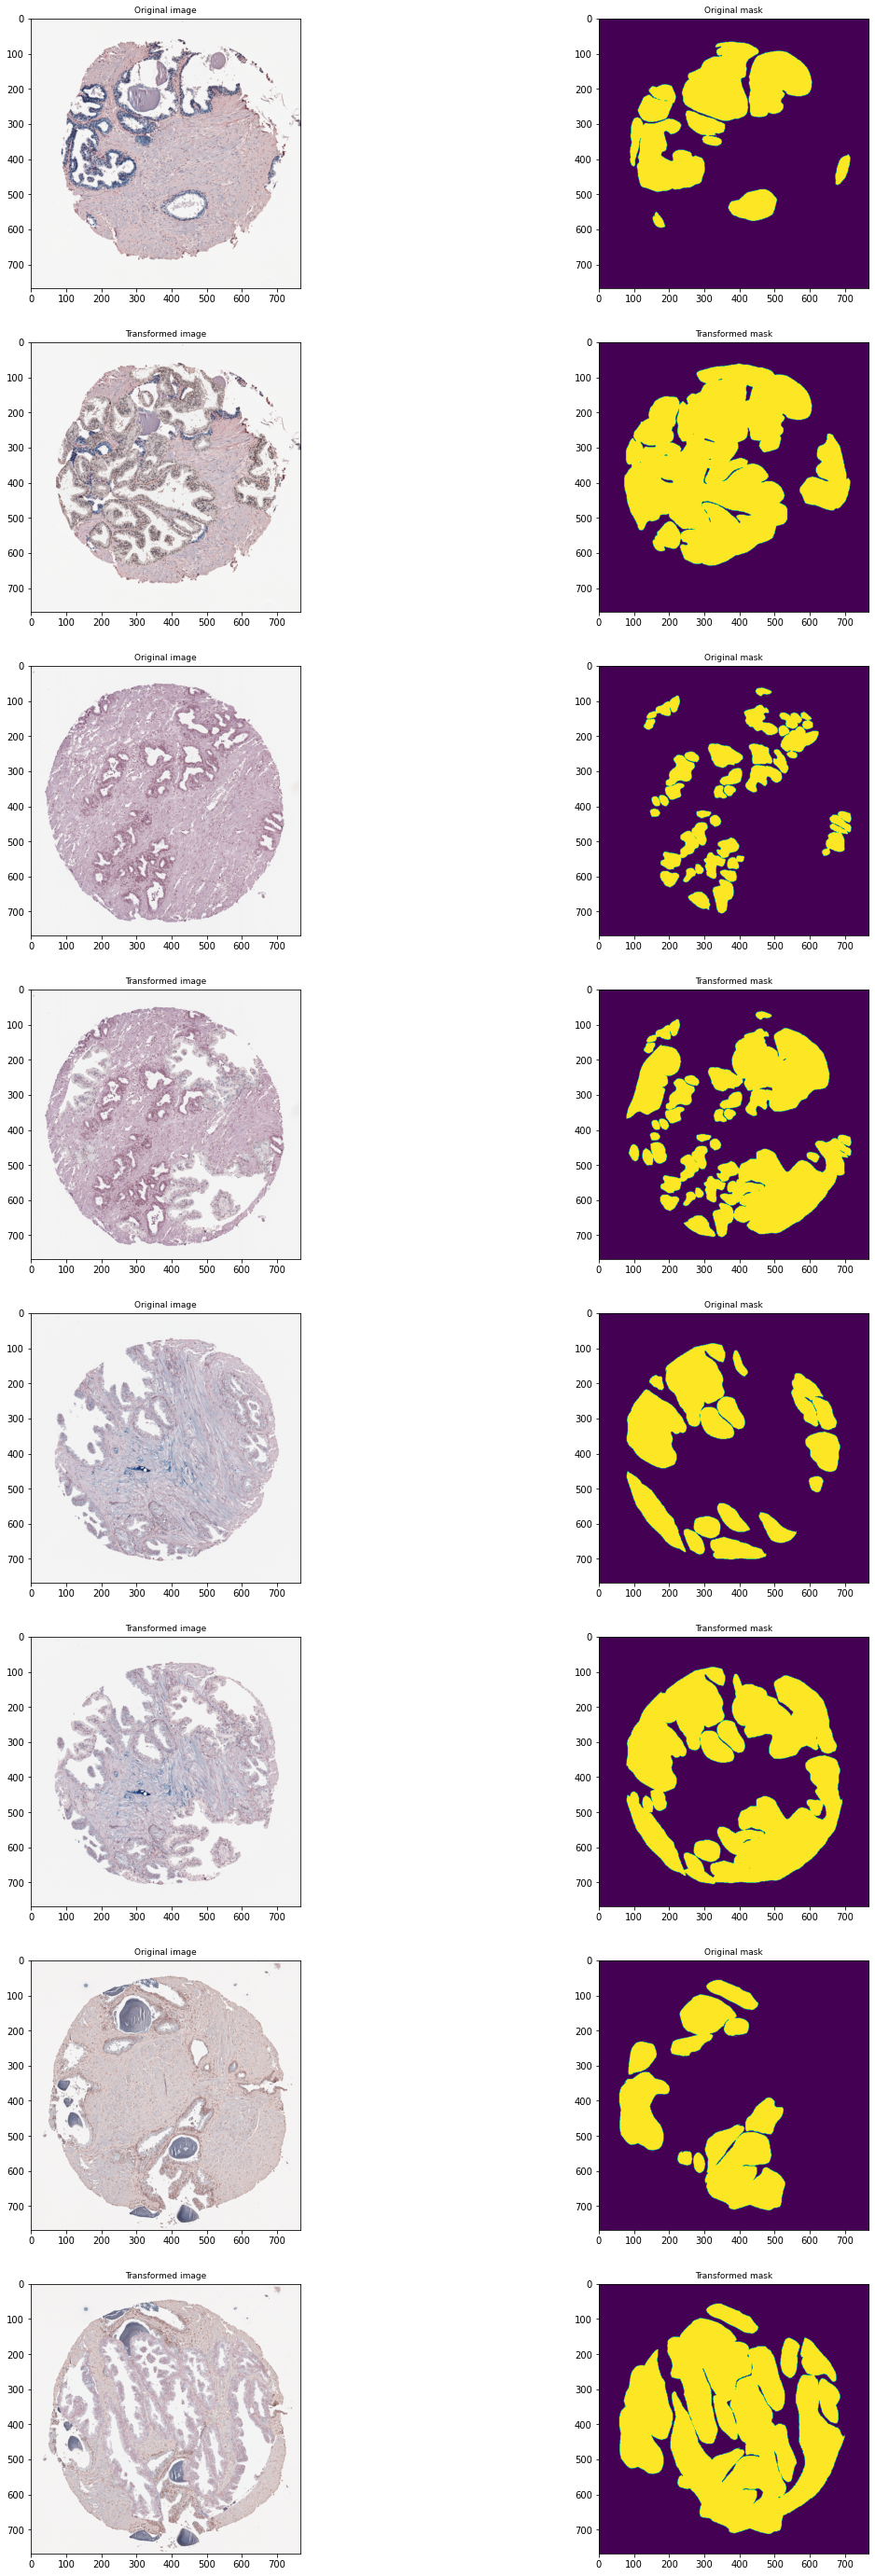

In [15]:

def visualize(examples,):
    fontsize = 9
    f, ax = plt.subplots(len(examples), 2, figsize=(20, 50))
    for i,ex in enumerate (examples):
        if i %2 == 0:
            original_image = np.array( Image.open(ex[0]))
            original_mask = np.array( Image.open(ex[1]))
            ax[i, 0].imshow(original_image)
            ax[i, 0].set_title('Original image', fontsize=fontsize)

            ax[i, 1].imshow(original_mask)
            ax[i, 1].set_title('Original mask', fontsize=fontsize)
        else: 
            original_image = np.array( Image.open(ex[0]))
            original_mask = np.array( Image.open(ex[1]))
            ax[i, 0].imshow(original_image)
            ax[i, 0].set_title('Transformed image', fontsize=fontsize)

            ax[i, 1].imshow(original_mask)
            ax[i, 1].set_title('Transformed mask', fontsize=fontsize)

visualize(examples[:8])

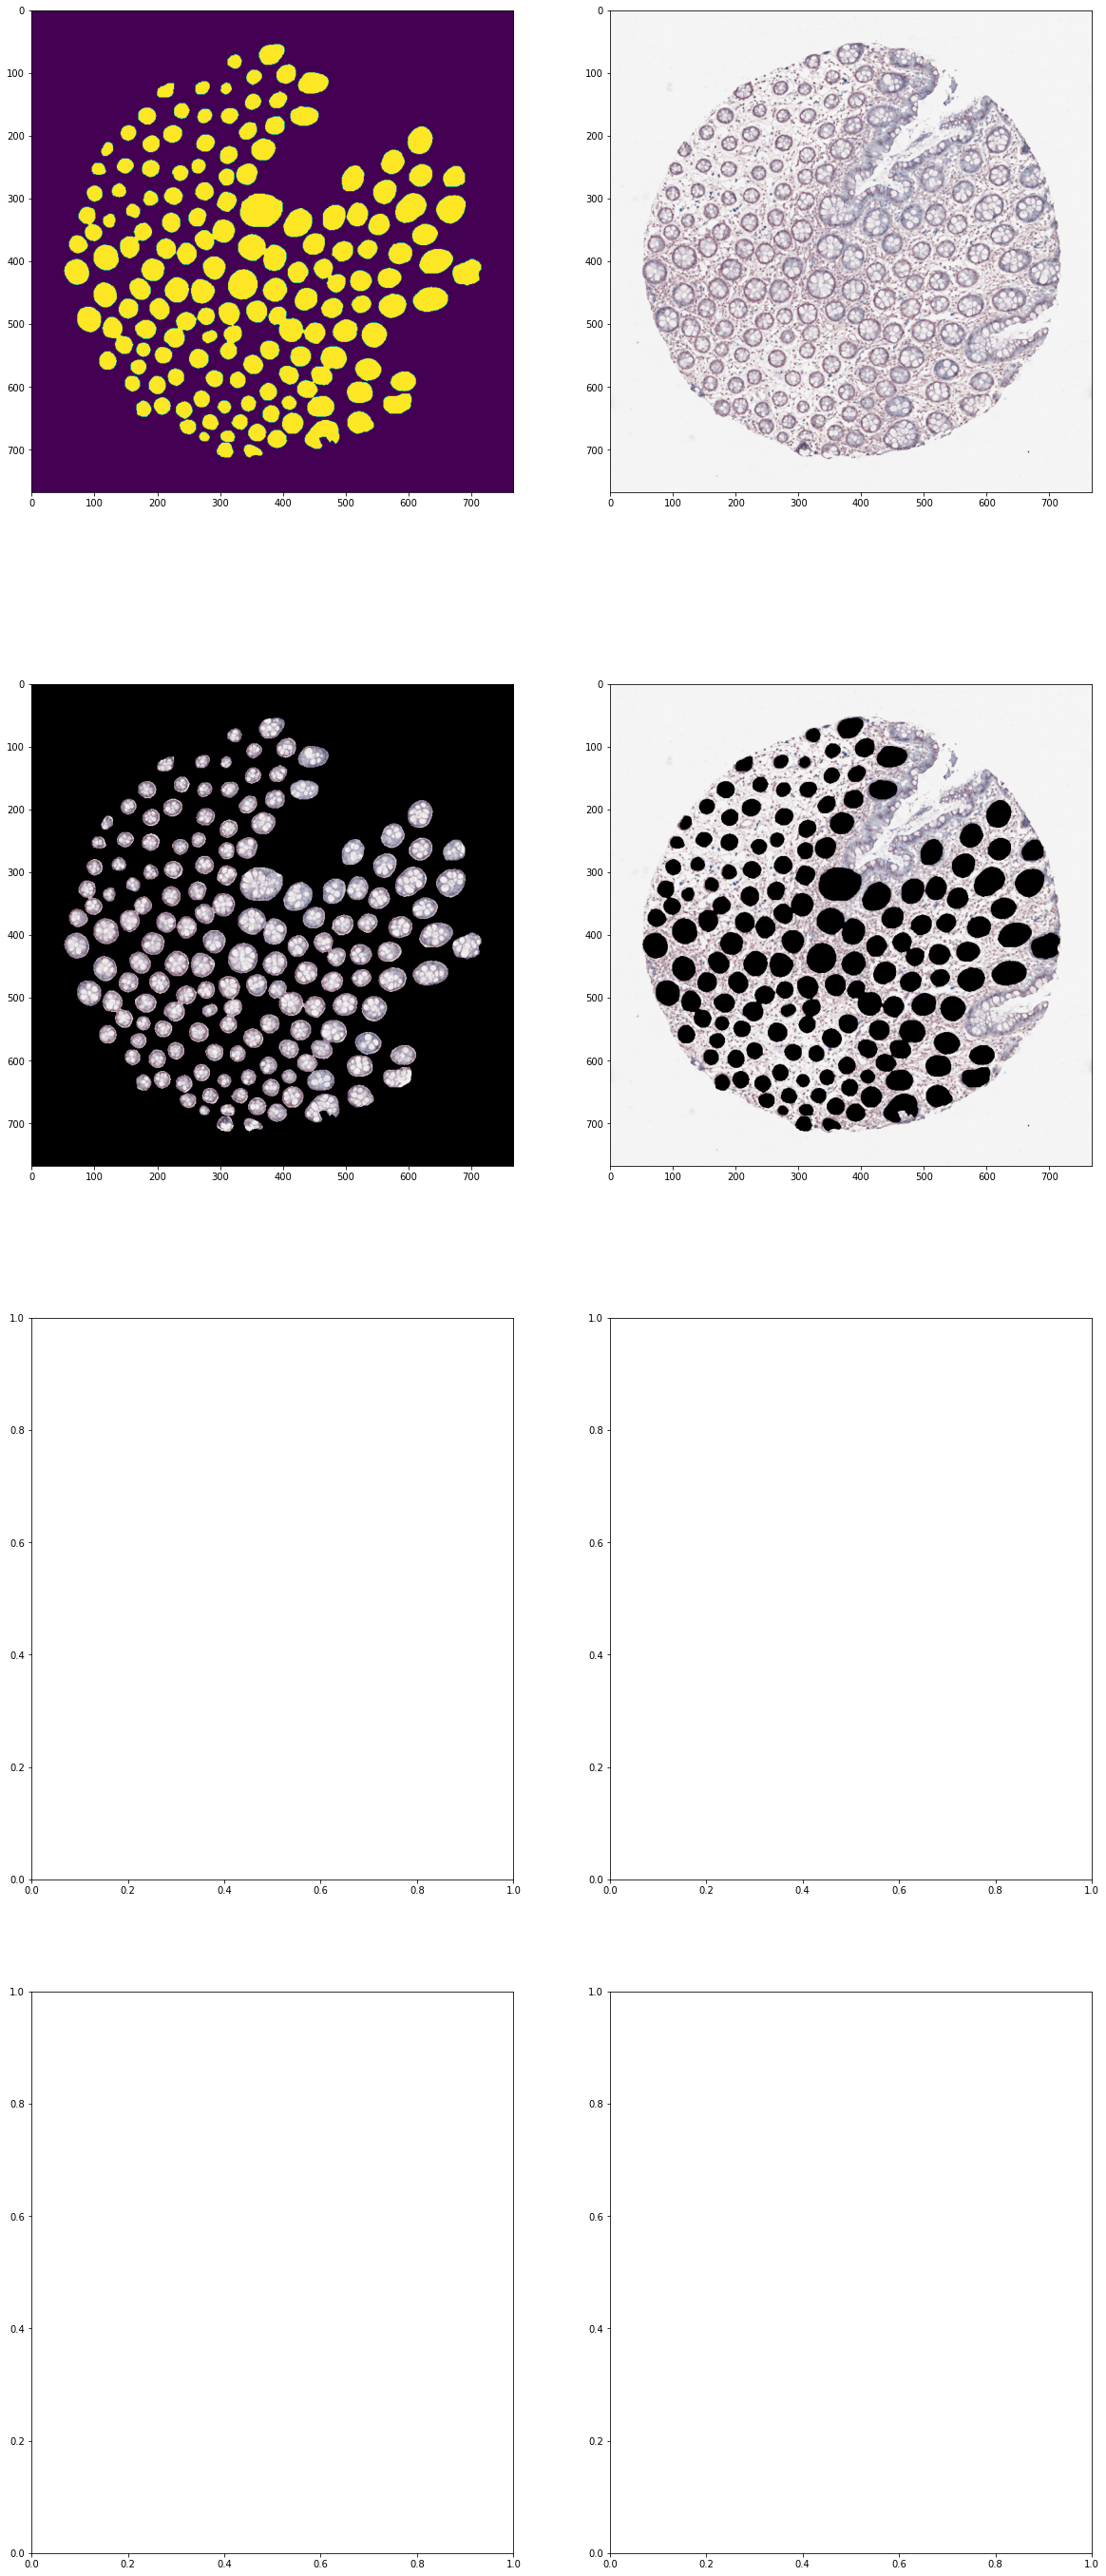

In [16]:
from PIL import Image
import cv2
import argparse
import os
import numpy as np
import tqdm
import pandas as pd
import collections
import random
from tqdm import tqdm
from matplotlib import pyplot as plt
i = 203
sm = f"/home/wangjingqi/input/hubmap-organ-segmentation/{config.image_size}/train_masks/{i}.png"
s = f"/home/wangjingqi/input/hubmap-organ-segmentation/{config.image_size}/train_images/{i}.png"

original_image =cv2.imread(s) 
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_mask = np.array( Image.open(sm),dtype=np.uint8)
# original_mask = cut(original_mask)


image = cv2.add(original_image, np.zeros(np.shape(original_image), dtype=np.uint8), mask=original_mask*255)
t_image = original_image - image
f, ax = plt.subplots(4, 2, figsize=(20, 50))


        
ax[0, 0].imshow(original_mask)
ax[0, 1].imshow(original_image)
ax[1, 0].imshow(image)
ax[1, 1].imshow(t_image)

In [17]:
original_mask0 = np.array( Image.open(sm),dtype=np.uint8)
original_mask1 = cv2.imread(sm,cv2.IMREAD_GRAYSCALE)

In [18]:
(np.ones(original_mask1.shape)*[original_mask1>1]).sum()


126857.0

In [19]:
768/16

48.0